<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Recomendando Música

El objetivo de este caso-taller es construir un sistema de recomendación de Música utilizando los datos de [Last.fm](https://www.last.fm/) provistos  abiertamente por [grouplens](https://grouplens.org/about/what-is-grouplens/) para: **"avanzar la teoría y la práctica de la computación social mediante la construcción y la comprensión de sistemas *(de recomendación)* utilizados por personas reales".**

Los datos contienen información sobre artistas, usuarios, y las veces que estos escucharon sus canciones. Las bases se encuentran en los `Archivos de Laboratorio` en la carpeta `data`, allí también está disponible un archivo [README](data/readme.txt) que contiene más información sobre las bases.


## Instrucciones generales

1. Para desarrollar el *cuaderno*, primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1. Carga de datos 

En la carpeta `data` se encuentran los archivos:

   - `artists.dat`  que contienen el identificador del artista (`id`), nombre (`name`), link a la página del artista en last.fm (`url`), y link a la imagen del usuario (`pictureURL`), vale aclarar que varios de estos links están rotos. 
   - `user_artists.dat`  que contiene identificador del usuario (`userID`), nombre del artista que escuchó (`artistID`), y las veces que los escuchó (`weight`).

Cargue estos datos en su *cuaderno*:

   1. Para la base de artistas seleccione las columnas de identificador de artista (`id`) y nombre (`name`). Renombre estas columnas para poder hacer la unión con la base `user_artists.dat`.
   2. Para la base de usuarios y artistas, renombre las columnas de forma tal que se mantenga la consistencia para unir con la base anterior, y renombre la columna `weight` a `nro_reproducciones`.
   3. Una estas bases.
   

In [1]:
# Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Carga archivos 
artists_df = pd.read_csv('data/artists.dat', sep='\t', header=0)
user_artists_df = pd.read_csv('data/user_artists.dat', sep='\t', header=0)

# Renombra columnas
artists_df = artists_df.rename(columns={'id': 'artistID', 'name': 'artist_name'})
user_artists_df = user_artists_df.rename(columns={'weight': 'nro_reproducciones'})

merged_df = pd.merge(user_artists_df, artists_df, on='artistID', how='inner') 

merged_df=merged_df.drop(['url','pictureURL'],axis=1)
display(merged_df.head())
merged_df.shape

,userID,artistID,nro_reproducciones,artist_name
0,2,51,13883,Duran Duran
1,4,51,228,Duran Duran
2,27,51,85,Duran Duran
3,28,51,10,Duran Duran
4,62,51,528,Duran Duran


(92834, 4)

* En este paso se importan las librerias a utilizar en el desarrollo del caso, posteriormente se cargan los archivos de artistas y usuarios con id de artistas escuchados, se renombran las columnas para poder hacer el cruce entre los dos dataframe y así poder extraer el nombre del artista, luego del cruce se eliminan las columnas de 'url' y 'pictureURL' las cuales no necesitaremos en el proceso y por último tenemos un dataframe con **92.834** filas y **4** columnas.

### 2. Análisis preliminar. 

En esta sección exploraremos la base. Para ello responda las siguientes preguntas.

#### 2.1 ¿Cuantos usuarios y artistas hay en la base?


In [3]:
df=merged_df.copy()
Users=df['userID'].nunique()
print(f"\033[1mTotal de usuarios:\033[0m {Users}") 

artists=df['artistID'].nunique()
print(f"\033[1mTotal de artistas:\033[0m {artists}") 
df.shape

Total de usuarios: 1892
Total de artistas: 17632


(92834, 4)

* Se identifica que nuestros datos cuentan con un total de **1.892** usuarios que escuchan a **17.632** artistas.


#### 2.2 ¿Cuáles es la distribución de probabilidad del consumo por artista? (haga el calculo sin ponderar y ponderando por el numero de reproducciones) ¿Qué podemos inferir a partir de la comparación de ambas?

In [4]:
print(f"\033[1m% Distribución sin ponderar :\033[0m") 
distSP = (df['artist_name'].value_counts(normalize=True)*100).round(2)
distSP = distSP.sort_values(ascending=False)
print(distSP)
print()
print(f"\033[1m% Distribución ponderada :\033[0m") 
distP = ((df.groupby('artist_name')['nro_reproducciones'].sum() / df['nro_reproducciones'].sum())*100).round(2)
distP = distP.sort_values(ascending=False)
print(distP)

% Distribución sin ponderar :
Lady Gaga                0.66
Britney Spears           0.56
Rihanna                  0.52
The Beatles              0.52
Katy Perry               0.51
                         ... 
Tenorio Jr               0.00
Mortification            0.00
The Union Underground    0.00
Loser                    0.00
Les Chants de Nihil      0.00
Name: artist_name, Length: 17632, dtype: float64

% Distribución ponderada :
artist_name
Britney Spears         3.46
Depeche Mode           1.88
Lady Gaga              1.87
Christina Aguilera     1.53
Paramore               1.39
                       ... 
Harvey Milk            0.00
Hasan Cihat Örter      0.00
Hasan Dursun           0.00
Hasan Hüseyin Varol    0.00
ｍａｃｈｉｎｅ                0.00
Name: nro_reproducciones, Length: 17632, dtype: float64


In [5]:
# Tomar el top 10 de casos 
top_10_distSP = distSP.head(10)
top_10_artists = df[df['artist_name'].isin(top_10_distSP.index)]
top_10_distP = distP[distP.index.isin(top_10_distSP.index)].round(2)

# Crear un DataFrame que contenga ambas distribuciones
result_df = pd.DataFrame({'Distribución sin ponderar (%)': top_10_distSP,
                          'Distribución ponderada (%)': top_10_distP})
result_df = result_df.sort_values(by='Distribución sin ponderar (%)', ascending=False)
# Mostrar el DataFrame resultante
result_df

,Distribución sin ponderar (%),Distribución ponderada (%)
Lady Gaga,0.66,1.87
Britney Spears,0.56,3.46
Rihanna,0.52,1.31
The Beatles,0.52,0.96
Katy Perry,0.51,0.77
Madonna,0.46,1.33
Avril Lavigne,0.45,0.76
Christina Aguilera,0.44,1.53
Muse,0.43,0.70
Paramore,0.43,1.39


* Se calcula la distribución de probabilidad de consumo de cada artista con base al número de reproducciones, en donde inicialmente se obtiene una distribución de frecuencias (sin ponderar) con la cantidad promedio de veces que cada artista ha sido escuchado, sin tener en cuenta el número de reproducciones. Posteriormente se calcula la distribución de probabilidad ponderada en donde se tiene en cuenta el número de reproducciones de cada artista, lo que significa que artistas con más reproducciones tendrán una mayor ponderación en la distribución.


* Se extrae el top 10 de artistas con distribución por frecuencias y se observa que por ejemplo que Lady Gaga tiene el 0.66% de participación en los usuarios que la escuchan con una distribución ponderada por número de reproducciones de 1.86%, sin embargo Britney Spears con el 0.56% de participación tiene una distribución ponderada mayor del 3,45%.


* En general el porcentaje de artistas con una probabilidad de consumo mayor al 1% fue del 5,14%

#### 2.3 Para el usuario 8 (`userID==8`) ¿cuál es la distribución de reproducción de artistas basado en el número de reproducciones relativas?. Presente sus resultados usando tablas y/o gráficas. ¿Encuentra algún patrón en los artistas que escucha y las veces que reproduce? ¿Podemos decir algo de sus preferencias?


Descriptivos de Distribución de reproducciones relativas:


,count,mean,std,min,25%,50%,75%,max
nro_reproducciones,50.0,1.9998,2.584233,0.48,0.96,1.34,2.14,17.34


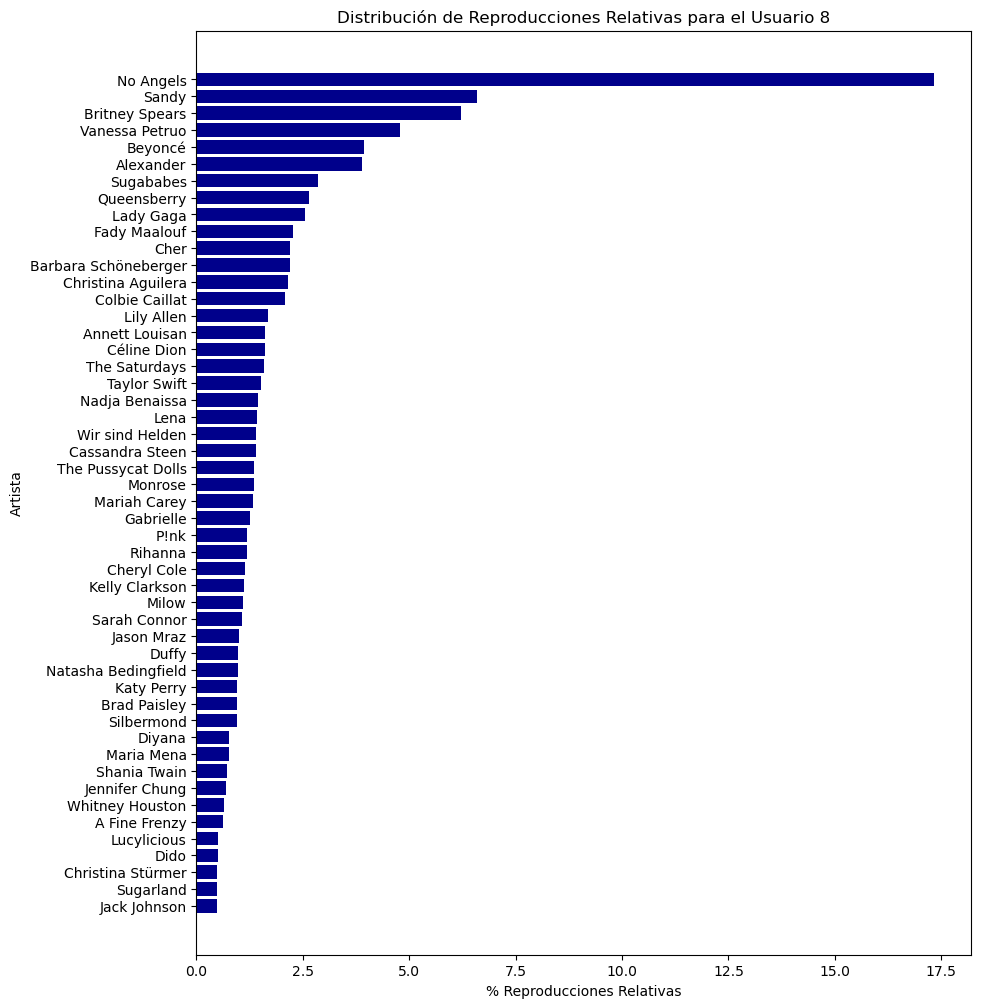

In [6]:
user_8_df = merged_df[merged_df['userID'] == 8]
# Calcular la distribución de reproducciones relativas
distribution_user_8 = (user_8_df.groupby('artist_name')['nro_reproducciones'].sum() / user_8_df['nro_reproducciones'].sum() * 100).round(2)
distribution_user_8 = distribution_user_8.sort_values(ascending=False)

# Tabla de distribución de reproducciones relativas
print("\033[1mDescriptivos de Distribución de reproducciones relativas:\033[0m") 
display(pd.DataFrame(distribution_user_8.describe()).T)

# Gráfico de barras para visualizar la distribución
plt.figure(figsize=(10, 12))
plt.barh(distribution_user_8.index, distribution_user_8.values, color='darkblue')
plt.xlabel('% Reproducciones Relativas')
plt.ylabel('Artista')
plt.title('Distribución de Reproducciones Relativas para el Usuario 8')
plt.gca().invert_yaxis()  # Invertir el eje y para mostrar el artista principal en la parte superior
plt.show()

* Para el Usuario 8, se evidencia que ha escuchado 50 artistas en donde en promedio tienen 1.9% del total de reproducciones pero "No angels" tiene hasta 17.3% del total de las reproducciones.

 
* Este usuario tiene un patron de coincidencia musical con el género pop debido a que más del 34% del total de reproducciones corresponde al top de los 5 artistas más escuchados


| Artista | Distribución Relativa|
|:---------------|---------------|
| No Angels      | 17.34         |
| Sandy          | 6.60          | 
| Britney Spears | 6.22          |
| Vanessa Petruo | 4.78          |
| Beyoncé        | 9.93          |  

### 3. Generando Recomendaciones

En esta sección nos interesa generar recomendaciones ***nuevas y relevantes*** para el usuario 8 (`userID==8`). Para ello vamos a generar distintos sistemas de recomendación y comparar las recomendaciones generadas.

#### 3.1. Filtrado colaborativo sencillo: promedios simples.

Usando el promedio simple de reproducciones (sin considerar el número de reproducciones) genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones.

In [7]:
df = df.drop_duplicates(subset=['userID', 'artistID'])
df.shape

(92834, 4)

,artist_name,average_frequency
0,The Beatles,0.253834
1,Madonna,0.226864
2,Avril Lavigne,0.220518
3,Muse,0.211528
4,Paramore,0.210999
5,Radiohead,0.207827
6,Coldplay,0.195135
7,Ke$ha,0.191433
8,Shakira,0.168694
9,Black Eyed Peas,0.160762


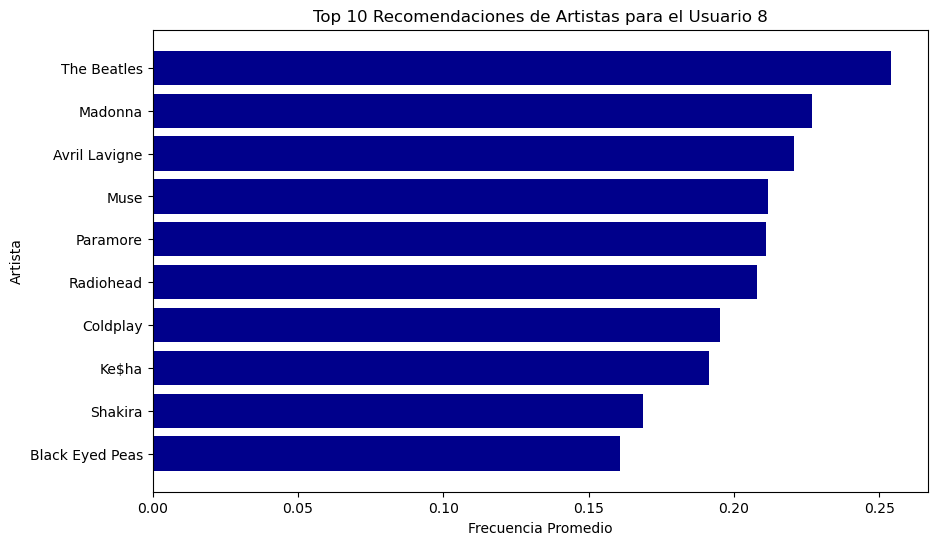

In [8]:
# Calcula la frecuencia 
artist_frequency = df[df['userID'] != 8]['artistID'].value_counts().reset_index()
artist_frequency.columns = ['artistID', 'frequency']
# Calcula el promedio por artista
artist_frequency['average_frequency'] = artist_frequency['frequency'] / (len(df['userID'].unique()) - 1)

# Buscar artistas diferentes a los que el usuario 8 acostumbra a escuchar
user_8_artists = df[df['userID'] == 8]['artistID']
artist_recommendations = artist_frequency[~artist_frequency['artistID'].isin(user_8_artists)]
artist_recommendations = artist_recommendations.merge(df[['artistID', 'artist_name']].drop_duplicates(subset=['artistID', 'artist_name']), on='artistID', how='left')

# ordena
artist_recommendations = artist_recommendations.sort_values(by='average_frequency', ascending=False)
top_10_recommendations = artist_recommendations.head(10)

display(top_10_recommendations[['artist_name', 'average_frequency']])

# gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_recommendations['artist_name'], top_10_recommendations['average_frequency'], color='darkblue')
plt.xlabel('Frecuencia Promedio')
plt.ylabel('Artista')
plt.title('Top 10 Recomendaciones de Artistas para el Usuario 8')
plt.gca().invert_yaxis()  # Invertir el eje al orden superior
plt.show()

* Inicialmente se confirma que el dataframe no contiene duplicados, posteriormente se aplica filtrado colaborativo sencillo a través de un promedio simple para identificar los 10 artistas que se recomendarán al usuario 8 sin tener en cuenta los artistas que ya escucha él actualmente. Para lo anterior se calcula la frecuencia de reproducción de cada artista, posteriormente, se determina el promedio de la frecuencia de reproducción por artista y el resultado se ordena de forma descendente según la frecuencia promedio para seleccionar los 10 artistas principales. En este caso se están recomendando artistas de genero rock-pop, el cuál está asociado al genero principal del artista.

#### 3.2.  Filtrado colaborativo sencillo: promedios ponderados.

Usando el promedio ponderado basado en el número de usuarios que escucha un artista  y ponderando  por el número de veces que estos usuarios reproducen al artista (`nro_reproducciones`) genere una tabla y/o gráfica con 10 recomendaciones de artistas para este usuario. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.

,artist_name,weighted_avg_reproductions
0,Depeche Mode,1301308.0
1,Paramore,963449.0
2,Madonna,921198.0
3,Shakira,688529.0
4,The Beatles,662116.0
5,Avril Lavigne,525844.0
6,Evanescence,513476.0
7,Glee Cast,506453.0
8,U2,493024.0
9,Miley Cyrus,489065.0


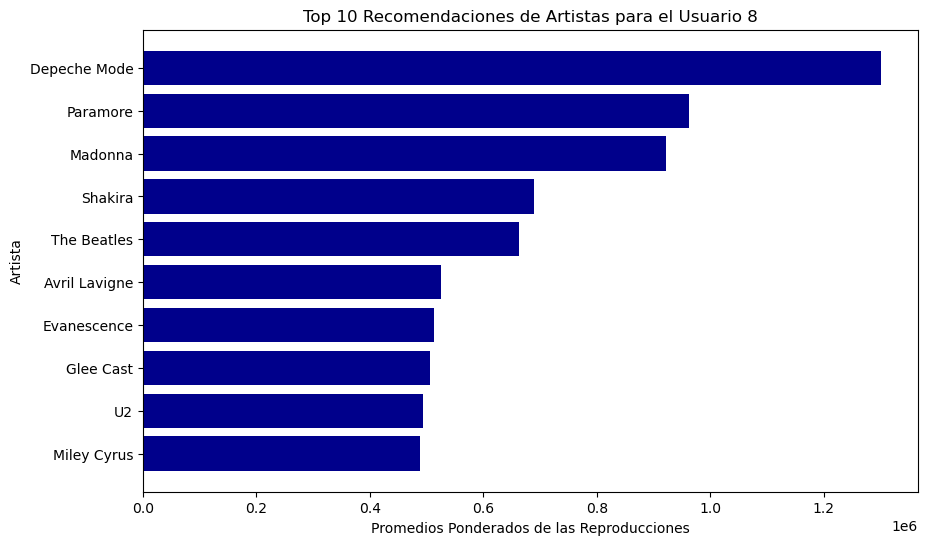

In [9]:
total_reproducciones_por_artista = df.groupby('artistID')['nro_reproducciones'].sum()
# Calcular el promedio ponderado de reproducciones por ID de artista
def calcular_promedio_ponderado(group):
    artista = group['artistID'].iloc[0]
    total_artista = total_reproducciones_por_artista[artista]
    return (group['nro_reproducciones'] * total_artista).sum() / total_artista

artist_reproduction_avg = df.groupby('artistID').apply(calcular_promedio_ponderado).reset_index(name='promedio_ponderado')
artist_reproduction_avg.columns = ['artistID', 'weighted_avg_reproductions']

# Filtrar los artistas que el usuario 8 aún no haya escuchado
artist_recommendations = artist_reproduction_avg[~artist_reproduction_avg['artistID'].isin(user_8_artists)]
artist_recommendations = artist_recommendations.merge(df[['artistID', 'artist_name']]. \
drop_duplicates(subset=['artistID', 'artist_name']), on='artistID', how='left')
# Ordena
artist_recommendations = artist_recommendations.sort_values(by='weighted_avg_reproductions', ascending=False)
top_10_recommendations = artist_recommendations.head(10)

display(top_10_recommendations[['artist_name', 'weighted_avg_reproductions']].reset_index(drop=True))

# gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_recommendations['artist_name'], top_10_recommendations['weighted_avg_reproductions'], color='darkblue')
plt.xlabel('Promedios Ponderados de las Reproducciones')
plt.ylabel('Artista')
plt.title('Top 10 Recomendaciones de Artistas para el Usuario 8')
plt.gca().invert_yaxis()  # Invertir el eje al orden superior
plt.show()

En este punto se calcula el promedio ponderado de reproducciones por ID de artista, en donde a través de una función se toma en cuenta el número de reproducciones y el total de reproducciones para cada artista. Luego, se filtran los artistas que el usuario 8 aún no ha escuchado para seleccionar por mayor promedio ponderado de reproducciones los 10 artistas principales. En este caso se evidencia que la recomendación incluye 5 artistas recomendados en el filtro colaborativo de promedios simples y 5 nuevos artistas en los que sobresale Depeche Mode con el género Synth-pop

#### 3.3.  Filtrado colaborativo sencillo: similitud de coseno.

Usando el promedio ponderado de reproducciones genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario. Para generar los pesos utilice la distancia de coseno. Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en el paso anterior.

,artist_name,promedio_ponderado_artistas
0,The Beatles,662116.0
1,Muse,485076.0
2,Radiohead,385306.0
3,Coldplay,330757.0
4,Arctic Monkeys,288520.0
5,The Killers,191979.0
6,Sigur Rós,133955.0
7,The Strokes,130227.0
8,Interpol,81822.0
9,The National,49647.0


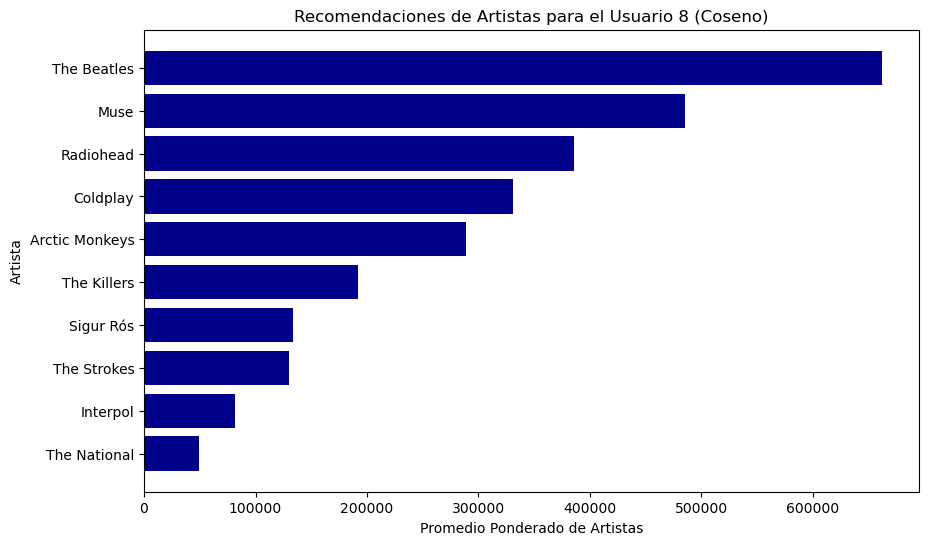

In [10]:
# Utilice este espacio para escribir el código.
# Calcula el promedio ponderado 
promedio_ponderado_artistas = df.groupby('artistID').apply(calcular_promedio_ponderado).reset_index(name='promedio_ponderado')
# Construye una matriz de preferencias de usuarios  por artistas
matriz_preferencias = df.pivot(index='userID', columns='artistID', values='nro_reproducciones').fillna(0)

# Calcula la similitud de coseno entre el usuario 8 y todos los demás usuarios
similitud_coseno = cosine_similarity(matriz_preferencias)
similitud_usuario_8 = similitud_coseno[8]  # Similitud del usuario 8 con otros usuarios

# Calcula las recomendaciones ponderando por la similitud de coseno
recomendaciones = np.dot(similitud_usuario_8, matriz_preferencias)

# Establece las recomendaciones para los artistas que el usuario 8 ya ha escuchado a cero
artistas_usuario_8 = df[df['userID'] == 8]['artistID'].unique()
for usuario_id in artistas_usuario_8:
    recomendaciones[usuario_id] = 0

# Encuentra los índices de los artistas recomendados
indices_artistas_recomendados = np.argsort(recomendaciones)[::-1][:10]

# Obtiene los 10 artistas recomendados 
artistas_recomendados = promedio_ponderado_artistas.loc[indices_artistas_recomendados]
artistas_recomendados.columns = ['artistID', 'promedio_ponderado_artistas'] #Encabezados
reco_coseno = artistas_recomendados.merge(df[['artistID', 'artist_name']].drop_duplicates(), on='artistID', how='left')
reco_coseno = reco_coseno.sort_values(by='promedio_ponderado_artistas', ascending=False)

display(reco_coseno[['artist_name', 'promedio_ponderado_artistas']].reset_index(drop=True))

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
plt.barh(reco_coseno['artist_name'], reco_coseno['promedio_ponderado_artistas'], color='darkblue')
plt.xlabel('Promedio Ponderado de Artistas')
plt.ylabel('Artista')
plt.title('Recomendaciones de Artistas para el Usuario 8 (Coseno)')
plt.gca().invert_yaxis()  # Invertir el eje y para que el artista con el promedio más alto esté en la parte superior

plt.show()

En este paso se aplica el filtrado colaborativo sencillo a través de similitud de coseno, para esto se toma el promedio ponderado de reproducciones, luego, se construye una matriz de preferencias de usuarios por artistas a partir de los datos proporcionados, posteriormente se calcula la similitud de coseno entre el usuario 8 y todos los demás usuarios. Utilizando esta similitud, se generan recomendaciones ponderadas, se ajustan las recomendaciones para los artistas que el usuario 8 ya ha escuchado a cero y se identifican el top 10 de los artistas recomendados. En este caso las recomendaciones aunque no son 100% pop se encuentran artistas de rock-pop. 

#### 3.4.  Filtrado colaborativo usando SVD


Usando la descomposición en valores singulares (SVD) genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores.


,artist_name,Puntuacion
0,Apparat,13415.0
1,Venetian Snares,9562.0
2,Antonio Vivaldi,9144.0
3,Paolo Nutini,7382.0
4,Virgin Prunes,2603.0
5,Ney Matogrosso,1525.0
6,Piano Magic,902.0
7,Artista desconhecido,463.0
8,Johnny Hates Jazz,430.0
9,Helrunar,52.0


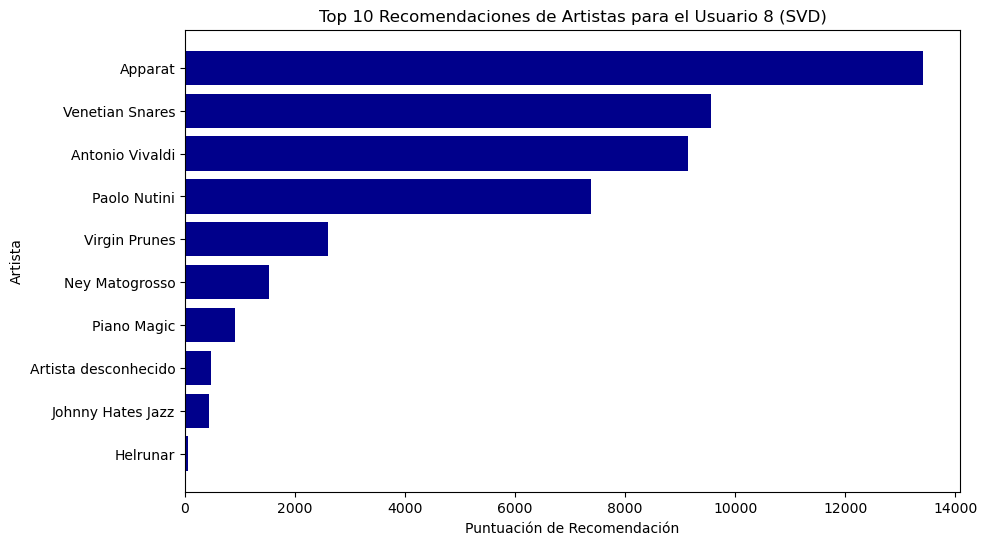

In [11]:
# Utilice este espacio para escribir el código.
# Realiza la descomposición SVD de la matriz de preferencias
svd = TruncatedSVD(n_components=10)  # Elige el número de componentes (puedes ajustarlo)
matriz_svd = svd.fit_transform(matriz_preferencias)

# Calcula las recomendaciones para el usuario 8 utilizando la matriz SVD
usuario_svd = matriz_svd[8]
recomendaciones_svd = np.dot(matriz_svd, usuario_svd)

# Encuentra los artistas que el usuario 8 ya ha escuchado
artistas_usuario_8 = df[df['userID'] == usuario_id]['artistID'].unique()

# Establece en 0 las recomendaciones para los artistas que del usuario 8
for usuario_id in artistas_usuario_8:
    recomendaciones_svd[8] = 0

# índices
indices_artistas_recomendados = np.argsort(recomendaciones_svd)[::-1][:10]

# Obtiene los 10 artistas recomendados y sus puntuaciones
artistas_recomendados_svd = promedio_ponderado_artistas.loc[indices_artistas_recomendados]
artistas_recomendados_svd.columns = ['artistID', 'Puntuacion']

# Agrega el nombre del artista 
reco_svd = artistas_recomendados_svd.merge(df[['artistID', 'artist_name']].drop_duplicates(), on='artistID', how='left')
reco_svd = reco_svd.sort_values(by='Puntuacion', ascending=False)

display(reco_svd[['artist_name', 'Puntuacion']].reset_index(drop=True))

plt.figure(figsize=(10, 6))
plt.barh(reco_svd['artist_name'], reco_svd['Puntuacion'], color='darkblue')
plt.xlabel('Puntuación de Recomendación')
plt.ylabel('Artista')
plt.title('Top 10 Recomendaciones de Artistas para el Usuario 8 (SVD)')
plt.gca().invert_yaxis()
plt.show()


En este paso se aplica el filtrado colaborativo usando descomposición en valores singulares, en donde se realiza un proceso de recomendación sobre la matriz de preferencias de usuarios por artistas. Inicialmente, se lleva a cabo la descomposición SVD reduciendo la dimensionalidad a 50 componentes y luego se calculan las recomendaciones para el usuario 8 utilizando esta matriz SVD.Se ajusta la matrix con 0 para los artistas que el usuario ya ha esuchado y por último se identifican y almacenan los artistas recomendados junto con sus puntuaciones en 'reco_svd'. En este caso se están recomendando artistas de géneros diferentes los cuáles pueden no ser de interes del usuario 8 ya que tiene una variedad de generos como rock, soul, etc.

#### 3.5.  Filtrado colaborativo usando Análisis de Canasta de Compra

Usando  el algoritmo `Apriori` genere una tabla y/o gráfica  con 10 recomendaciones de artistas para este usuario.  Explique con cuidado su procedimiento y justifique sus elecciones. Compare las recomendaciones con el sistema implementado en los pasos anteriores. Esto puede tomar mucho tiempo, sea cuidadoso al elegir los hiper-parámetors del modelo, utilice los resultados de las estadísticas descriptivas para elegir sus hiper-parámetros, y genere solo reglas con 2 elementos. (Puede también aprovechar los recursos de [Google Colab](https://colab.research.google.com/))


,artist_name,lift
0,Girls Aloud,12.236816
1,Leona Lewis,7.153395
2,Adele,6.757143
3,Ashlee Simpson,6.751929
4,Selena Gomez & the Scene,5.375000
5,Nelly Furtado,5.367993
6,Hilary Duff,5.252100
7,Jennifer Lopez,4.917479
8,Ashley Tisdale,4.748609
9,Michael Jackson,4.741855


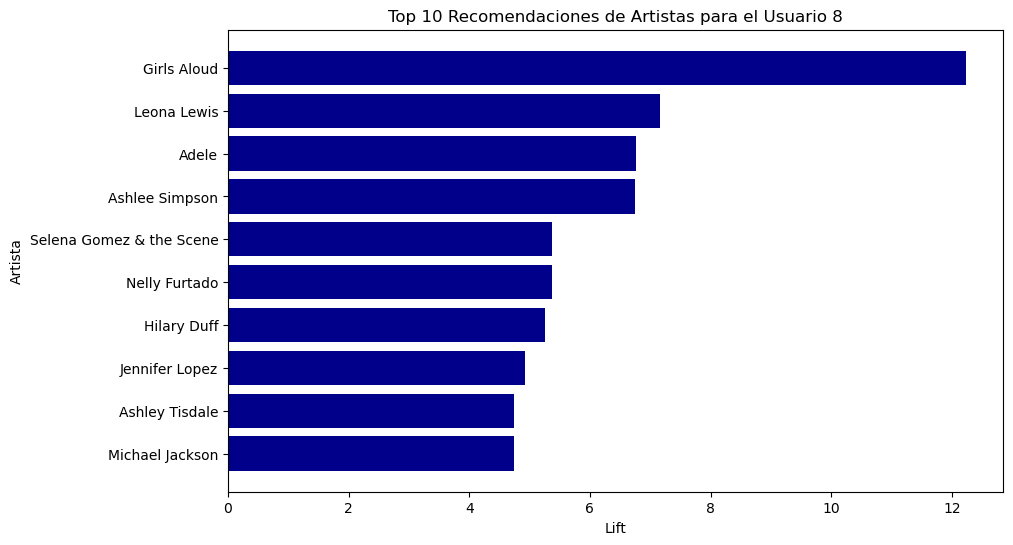

In [12]:
from apyori import apriori

# Establecer el formato lista de listas
records = []
usuarios = df['userID'].unique().tolist()

for i in usuarios:
    records.append(list(df[df['userID'] == i]['artistID'].values))
    
# Artistas que se escuchan al menos 1% de las veces, con cofianza mínima de 0.4, min_lift de 4 y max_length de 2 
association_rules = apriori(records, min_support=0.01, min_confidence=0.4, min_lift=4,max_length=2)
association_results = list(association_rules)

# Dataframe para guardar los artistas a recomendar
reco_apriori_df = pd.DataFrame(columns=["artistID", "confianza", "lift"])

for rule in association_results:
    
    id_artista_antecedente = int(str(set(rule[2][0].items_base)).strip("{}"))
    id_artista_consecuente = int(str(set(rule[2][0].items_add)).strip("{}"))
    
    #Verificar que la Refla Antecedente sea un Artista del usuario 8 y que la regla consecuente no sea un artista del usuario 8
    if  id_artista_antecedente in records[usuarios.index(8)] and id_artista_consecuente not in records[usuarios.index(8)]:
        
        artista_antecedente = df[df['artistID'] == id_artista_antecedente]['artist_name'].iloc[0]
        artista_consecuente = df[df['artistID'] == id_artista_consecuente]['artist_name'].iloc[0]
        
        # Agregar datos al dataframe
        reco_apriori_df = reco_apriori_df.append({"artistID": id_artista_consecuente, \
        "confianza": float(rule[2][0][2]), "lift": float(rule[2][0][3]),  \
        "artist_name": artista_consecuente}, ignore_index=True)
        
# Ordena
artist_reco_apriori = reco_apriori_df.sort_values(by='lift', ascending=False)

# Eliminar duplicados
artist_reco_apriori_sin_duplicados = artist_reco_apriori.drop_duplicates(subset='artist_name', keep='first')

# Tomar los primeros 10 artistas después de eliminar duplicados
top_10_recommendations = artist_reco_apriori_sin_duplicados.head(10)

display(top_10_recommendations[['artist_name', 'lift']].reset_index(drop=True))

# gráfico
plt.figure(figsize=(10, 6))
plt.barh(top_10_recommendations['artist_name'], top_10_recommendations['lift'], color='darkblue')
plt.xlabel('Lift')
plt.ylabel('Artista')
plt.title('Top 10 Recomendaciones de Artistas para el Usuario 8')
plt.gca().invert_yaxis()  # Invertir el eje al orden superior
plt.show()

* En este paso se aplica el filtro colaborativo usando el análisis de canasta de compra, a través del algoritmo **apriori**

* Los datos transforman como una lista de listas para que el algoritmo los pueda procesar, luego se seleccionan el parámetro **min_support = 0.01**, el cual está relacionado con la probabilidad que tiene un artista de ser escuchado, y según las estadísticas descriptivas corresponde al 5% de los artistas. Por otra parte están los parámetros **min_confidence=0.4** y **min_lift=4**, los cuales serían la mínima propabilidad con la que un usuario escuche determinado artista y cuantas veces más alta sea la probabilidad de que se escuchen dos artistas juntos a que se escuchen independientemente.

* se obtienen los artistas a recomendar con base en el indicador lift, que entre más alto sea, más útiles serán las reglas de asociación definidas por la técnica usada.

* Esta técnica de filtrado es útil en este caso para recomendar artistas en función de los patrones de consumo de otros usuarios. En este caso se encontró que los artistas escuchados por este usuario tenían una fuerte asociación con otros artistas, los cual sugrió de las relaciones definidas por el modelo al procesar todos los usuarios en el conjunto de datos.

* Al analizar las recomendaciones se sigue una fuerte tendencia al género fuerte del usuario como lo es el pop, el cual está presenta en el top ten de artistas recomendados por esta técnica, a diferencia de las anteriores donde si estaba presente el pop, pero con algunos otras variaciones como lo son el rock-pop, Synth-pop y soul.

### 4. Recomendaciones generales 

De acuerdo con los resultados encontrados, en su opinión ¿qué procedimiento generó las mejores recomendaciones para este usuario? ¿Cómo implementaría una evaluación objetiva de estas recomendaciones? Justifique su respuesta.

* De los 5 procedimientos usados para realizar el filtrado colaborativo, podríamos inferir que el **Filtrado colaborativo usando análisis de canasta de compra**, tuvo mejor desempeño que los demás procedimientos, por el hecho de que en su elección resaltó el género preferido del usuario, por otra parte en el contexto de los datos este modelo aplica perfectamente, ya que no tenemos calificaciones explícitas que representen preferencias o valoraciones de los usuarios sobre los artistas, en cambio las reproducciones pueden considerarse como una forma de interacción implicita, lo que significa que cuando un usuario reproduce una canción de un artista, eso implica un nivel de interés o preferencia por ese artista. Otra de las ventajas de este procedimiento sobre los otros es que puede identificar patrones de asociación entre artistas que suelen ser reproducidos juntos y en función de esos patrones, hacer recomendaciones de artistas que el usuario podría disfrutar


* La evaluación de las recomendaciones se podría hacer dividiendo los datos en conjuntos de entrenamiento y prueba con el cual se construya y evalue el modelo luego de que ya se cuente con datos de interacción entre los usuarios y el consumo de música, a través de métricas conocidas como la precisión, el recall, Curva ROC, etc.


* La evalución de las recomendaciones es importante para realizar el ajuste y optimización de los modelos ejecutados, si los resultados no son satisfactorios, se deben ajustar los hiperparámemtros del modelo o probar enfoques alternativos.